# Notes from *Lesson 3*

Using different models with the timm library

In [59]:
import os
import pandas as pd
import plotly.express as px
from ipywidgets import interact
from fastai.basics import *
from functools import partial

In [10]:
url = 'https://github.com/rwightman/pytorch-image-models.git'
command = f"git clone --depth 1 {url}"

os.system(command)

fatal: destination path 'pytorch-image-models' already exists and is not an empty directory.


32768

In [16]:
results_dir = 'pytorch-image-models/results'
filename = 'results-imagenet.csv'
results_path = os.path.join(results_dir,  filename)

df_results = pd.read_csv(results_path)

In [37]:
def get_data(part, col):
    filename = f'benchmark-{part}-amp-nhwc-pt111-cu113-rtx3090.csv'
    path = os.path.join(results_dir, filename)
    regex_pattern = '^([a-z]+?(?:v2)?)(?:\d|_|$)'
    df = pd.read_csv(path).merge(df_results, on='model')
    df['secs'] = 1./df[col]
    df['family'] = df.model.str.extract(regex_pattern)
    df = df[~df.model.str.endswith('gn')]

    df.loc[df.model.str.contains('in22'),'family'] = df.loc[df.model.str.contains('in22'),'family'] + '_in22'
    df.loc[df.model.str.contains('resnet.*d'),'family'] = df.loc[df.model.str.contains('resnet.*d'),'family'] + 'd'
    
    return df[df.family.str.contains('^re[sg]netd?|beit|convnext|levit|efficient|vit|vgg')]

df = get_data('infer', 'infer_samples_per_sec')

In [39]:
w, h = 1000, 800

def show_all(df, title, size):
    return px.scatter(df,
                      width=w,
                      height=h,
                      size=df[size]**2,
                      title=title,
                      x='secs',
                      y='top1',
                      log_x=True,
                      color='family',
                      hover_name='model',
                      hover_data=[size])
# show_all(df, 'Inference', 'infer_img_size')

## How does a neural network really work (from Jeremy's kaggle notebook)

In [57]:
plt.rc('figure', dpi=90)

def plot_function(f, title=None, x_min=None, x_max=None, color='r', ylim=None):
    x_min = x_min if x_min else -5.0
    x_max = x_max if x_max else 5.0
    print(x_min, x_max)

    x = torch.linspace(x_min, x_max, 100)[:, None]

    plt.figure(figsize=(5,2))
    plt.plot(x, f(x), color)
    if ylim: plt.ylim(ylim)
    if title is not None: plt.title(title)
    plt.grid()

-5.0 5.0


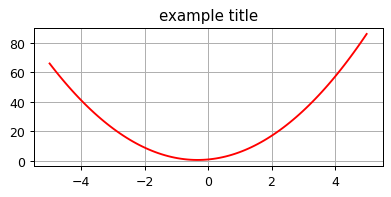

In [58]:
def f(x):
    return 3*x**2 + 2*x + 1

plot_function(f, 'example title')

In [65]:
def quad(a, b, c, x):
    return a*x**2 + b*x + c

print(quad(2,3,1,1.5))

def mk_quad(a, b, c):
    return partial(quad, a, b, c)

10.0


-5.0 5.0


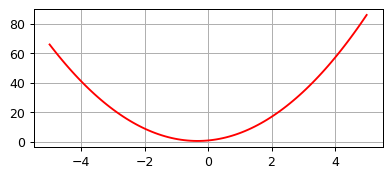

In [66]:
f2 = mk_quad(3,2,1)
plot_function(f2)

In [67]:
def noise(x, scale):
    return np.random.normal(scale=scale, size=x.shape)

def add_noise(x, mult, add):
    return x * (1+noise(x, mult)) + noise(x, add)

In [68]:
x = torch.linspace(-2, 2, steps=20)[:, None]
y = add_noise(f(x), 0.15, 0.15)